### Clone repo to access GPT2 weights

In [225]:
! git clone https://github.com/muxitox/nanoGPT.git

Cloning into 'nanoGPT'...
remote: Enumerating objects: 1357, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1357 (delta 2), reused 2 (delta 2), pack-reused 1353 (from 3)
Receiving objects: 100% (1357/1357), 28.03 MiB | 21.55 MiB/s, done.
Resolving deltas: 100% (656/656), done.


In [226]:
%cd nanoGPT

/home/apoc/Documents/projects/nanoGPT/simple_model/nanoGPT/nanoGPT/nanoGPT/nanoGPT/nanoGPT/nanoGPT/nanoGPT/nanoGPT/nanoGPT


### Imports

In [227]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from model import GPTConfig, GPT

import matplotlib.pyplot as plt
import time

In [228]:
!pip install ipdb
import ipdb


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Utils

In [229]:
def bitfield(n, size):  # Transform positive integer into bit array
    x = [int(x) for x in bin(int(n))[2:]]
    x = [0] * (size - len(x)) + x
    return torch.array(x)

#### Plotting

In [230]:
def return_subplot(num_feats):
    if num_feats == 1:
        fig, ax = plt.subplots(1, 1)
    elif num_feats == 2:
        fig, ax = plt.subplots(2, 1)
    elif num_feats == 3:
        fig, ax = plt.subplots(3, 1)
    else:
        fig, ax = plt.subplots(min(4, math.floor((num_feats)/2)), 2)

    return fig, ax

In [231]:
def subplot_trajectories(stats, label, line, title, domain_label, random_feats=False, max_feats_show=4):

    T, num_feats = stats[0].shape
    num_feats_show = min(num_feats, max_feats_show)

    fig, ax = return_subplot(num_feats_show)
    ax = ax.ravel()

    if max_feats_show > 4 and random_feats:
        feats = torch.randperm(stats[0].shape[1])[:num_feats_show]
    else:
        feats = torch.arange(num_feats_show)

    for i in range(0, num_feats_show):
        for s in range(len(stats)):
            ax[i].plot(stats[s][:,feats[i]], line[s], label=label[s])

            ax[i].set_ylabel(f"${domain_label}_{{{feats[i]}}}$")
            ax[i].set_xlabel(f"$t$")

        if i==num_feats_show - 1:
            ax[i].legend()
    plt.suptitle(title)

### Forward functions for the network

In [232]:
def forward(tok_emb_t_1, x_t, W_k, W_q, beta=1.0):
    # apply softmax to get probabilities
    k_t_1 = tok_emb_t_1 @ W_k.T
    q_t = x_t @ W_q.T
    Wk_Wq_x_t = W_k.T @ q_t  # Compute this also for comparison

    probs = F.softmax(beta * k_t_1 @ q_t, dim=0)

    # sample from the distribution
    idx_next = torch.multinomial(probs, num_samples=1)

    tok_t = tok_emb_t_1[idx_next][0]

    return tok_t, idx_next, Wk_Wq_x_t, q_t, probs

In [233]:
def forward_mf(mu, cov, tok_emb, W_k, W_q, beta):

    # Compute the probability of the text token
    k = tok_emb @ W_k.T
    p_k = beta * k @ mu + beta**2 * torch.einsum('ni,ij,nj->n', k, cov, k) / 2

    p_k = F.softmax(p_k, dim=0)

    max_k_idx = torch.argmax(p_k, dim=0)

    # Get the mean of x
    mu_x = torch.sum(p_k[:, None] * tok_emb, dim=0)

    mu_k = mu_x @ W_k.T
    mu_q = mu_x @ W_q.T

    q = tok_emb @ W_q.T
    q_centered = q - mu_q
    sigma_q = torch.einsum('n,nm,nk->mk', p_k, q_centered, q_centered)

    return mu_k, mu_q, sigma_q, max_k_idx, p_k

### Experiment settings

In [234]:
num_trials = 10000
num_running_steps = 5

### Network settings

In [235]:
beta = 1.3
binary_vars = False
q_is_roll = False  # If W_q a shift over W_k
patterns_from_vocab = True # If you draw samples from the token vocab to make the W patterns
emb_size = 500 # Number of tokens in the embedding. -1 if you want the full vocab size
num_patterns = 3  # Number of patterns in the W matrices. -1 if you want to match token_size
token_size = 250 # Number of features. If -1, match with the embedding token size, otherwise, force your selection.
random_ini_token = True
ini_token_idx = 0
# prev seed  150
seed = 158

torch.manual_seed(seed)


In [236]:
device = 'cpu'  # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.

if not binary_vars:

    # In this case instead of initializing from random varialbes, use GPT2 embeddings
    # as initialization (They are distributed in a Gaussian way for a large number of tokens).

    # Load GPT2
    model_name = "gpt2"
    model = GPT.from_pretrained(model_name, dict(dropout=0.0))
    model.to(device)

/home/apoc/Documents/projects/nanoGPT/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


In [237]:
####################
# Set up the vocabulary and weights
####################

# Define the tokens or spins
if binary_vars:    # Binary variables

    if token_size == -1:
        raise Exception("token_size must be defined")
    if num_patterns == -1:
        raise Exception("num_patterns must be defined")
    if emb_size == -1:
        raise Exception("emb_size must be defined")

    tok_emb = (torch.rand((emb_size, token_size), device=device) > 0.5).float()
    tok_emb = tok_emb * 2 - 1
else:   # Tokens from GPT2

    # Get embeddings to sample tokens from them
    wte = model.transformer.wte
    num_embeddings = wte.num_embeddings

    if token_size==-1:
        token_size = wte.embedding_dim

    if emb_size == -1:
      emb_size = num_embeddings

    if num_patterns == -1:
      num_patterns = token_size

    # Select emb_size tokens from the embedding to create a smaller vocabulary
    perm_tokens_idxs = torch.randperm(num_embeddings)
    tokens_idxs = perm_tokens_idxs[:emb_size]

    # Transform into token representation
    # Equivalent to x_{t+1} in the LaTeX doc
    tok_emb = model.transformer.wte(tokens_idxs).detach()
    perm_feats_idxs = torch.randperm(wte.embedding_dim)
    tok_emb = tok_emb[:, perm_feats_idxs[:token_size]]

# Define the W patterns

if patterns_from_vocab:

    if num_patterns > emb_size:
        raise Exception("num_patterns > emb_size")

    k_patts = torch.randperm(emb_size)[:num_patterns]
    q_patts = torch.randperm(emb_size)[:num_patterns]

    W_k = tok_emb[k_patts]
    W_q = tok_emb[q_patts]

    if binary_vars:
        W_k = W_k / math.sqrt(token_size)
        W_q = W_q / math.sqrt(token_size)
    else:

        tok_mean = torch.mean(tok_emb, dim=None)
        tok_mean_b = torch.mean(tok_emb, dim=0)
        k_mean = torch.mean(tok_emb[k_patts], dim=None)
        q_mean = torch.mean(tok_emb[q_patts], dim=None)
        k_std = torch.std(tok_emb[k_patts], dim=None)
        q_std = torch.std(tok_emb[q_patts], dim=None)

        tok_emb_std = torch.std(tok_emb, dim=None)
        tok_emb_std_b = torch.std(tok_emb, dim=0)

        scaling = torch.sqrt(tok_emb_std_b**2 + tok_mean_b**2)
        # FPC = 1 - (num_patterns / emb_size)
        # W_k = tok_emb[k_patts] / scaling
        # W_q = tok_emb[q_patts] / scaling
        #
        # J = (1 / math.sqrt(token_size * num_patterns)) * (W_k.T @ W_q)

        W_k = W_k / (scaling * (token_size * num_patterns)**(1/4))
        W_q = W_q / (scaling * (token_size * num_patterns)**(1/4))


    J = (W_k.T @ W_q)
    J_var = torch.var(J, dim=None)
    print("J variance", J_var, 1/token_size)
    print()

else:
    # Create random W patterns
    w_mean = 0
    # w_std = 1/math.sqrt(token_size)
    w_std = 1
    # num_patterns = token_size
    W_k = torch.normal(w_mean, w_std, (num_patterns, token_size))
    W_q = torch.normal(w_mean, w_std, (num_patterns, token_size))

    if binary_vars and not patterns_from_vocab:
        raise Exception("Behavior not programmed yet")

if q_is_roll:
    W_q = torch.roll(W_k, 1, 0)


J variance tensor(0.0046) 0.004



### Choose initial token

In [238]:
# Choose initial token
# Choose x_0
if random_ini_token:
    tok_0 = torch.randn((emb_size, token_size))[ini_token_idx]
else:
    # tok_0 = tok_emb[ini_token_idx]
    tok_0 = W_q[ini_token_idx]


### For debugging purposes

In [239]:
timesteps_to_examine = [0, 1, 2, 3]

timesteps_to_examine = [t for t in timesteps_to_examine if t < num_running_steps]
timesteps_to_examine_dict = dict([(k,v) for k, v in zip(timesteps_to_examine, range(len(timesteps_to_examine)))])



## Model without approximation

In [240]:
# Variables to save statistics
tok_stats_sim = torch.zeros((num_trials, num_running_steps, token_size))
idxs = torch.zeros((num_trials, num_running_steps))

# Create structure to save data from different runs
n_trials_to_examine = [1, 3]
n_trials_to_examine = [r for r in n_trials_to_examine if r < num_running_steps]
n_trials_to_examine_dict = dict([(k,v) for k, v in zip(n_trials_to_examine, range(len(n_trials_to_examine)))])

probs_sim_t = torch.zeros((len(n_trials_to_examine), len(timesteps_to_examine), emb_size))

In [241]:
################################################
# Compute the average over multiple trajectories (without approximation)
################################################

startt = time.time()
for r in range(num_trials):

    if r % 100 == 0:
        print(f"Trial {r+1}/{num_trials}")

    tok_t_1 = tok_0.clone()
    for t in range(num_running_steps):

        # Get the next token
        tok_t_1, idx_t_1, Wk_Wq_x_t, q_t, probs = forward(tok_emb, tok_t_1, W_k, W_q, beta)

        # Accumulate stats
        tok_stats_sim[r, t, :] += tok_t_1
        idxs[r, t] = idx_t_1
        if r in n_trials_to_examine and t in timesteps_to_examine:
            probs_sim_t[n_trials_to_examine_dict[r], timesteps_to_examine_dict[t]] = probs

endt = time.time()
time_elapsed = endt - startt
print(f"Time elapsed: {time_elapsed:.2f} seconds")

print("Selected tokens at each step")
print(idxs[0])
print(idxs[3])
print(idxs[100])
print(idxs[-1])

mode_idxs = torch.mode(idxs, 0).values


tok_stats_sim_avg = torch.mean(tok_stats_sim, dim=0)

Trial 1/10000
1 0
1 1
1 2
1 3
3 0
3 1
3 2
3 3
Trial 101/10000
Trial 201/10000
Trial 301/10000
Trial 401/10000
Trial 501/10000
Trial 601/10000
Trial 701/10000
Trial 801/10000
Trial 901/10000
Trial 1001/10000
Trial 1101/10000
Trial 1201/10000
Trial 1301/10000
Trial 1401/10000
Trial 1501/10000
Trial 1601/10000
Trial 1701/10000
Trial 1801/10000
Trial 1901/10000
Trial 2001/10000
Trial 2101/10000
Trial 2201/10000
Trial 2301/10000
Trial 2401/10000
Trial 2501/10000
Trial 2601/10000
Trial 2701/10000
Trial 2801/10000
Trial 2901/10000
Trial 3001/10000
Trial 3101/10000
Trial 3201/10000
Trial 3301/10000
Trial 3401/10000
Trial 3501/10000
Trial 3601/10000
Trial 3701/10000
Trial 3801/10000
Trial 3901/10000
Trial 4001/10000
Trial 4101/10000
Trial 4201/10000
Trial 4301/10000
Trial 4401/10000
Trial 4501/10000
Trial 4601/10000
Trial 4701/10000
Trial 4801/10000
Trial 4901/10000
Trial 5001/10000
Trial 5101/10000
Trial 5201/10000
Trial 5301/10000
Trial 5401/10000
Trial 5501/10000
Trial 5601/10000
Trial 5701/

In [242]:
idxs[0]

tensor([ 57., 248.,  57.,  81., 462.])

In [243]:
probs_sim_t[0,0,:]==probs_sim_t[1,0,:]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

## Model with approximation

In [244]:
# Variables to save stats
mu_q_t_1 = tok_0 @ W_q.T
cov_q_t_1 = torch.zeros((num_patterns, num_patterns))

stats_k_mf = torch.zeros((num_running_steps, num_patterns))
idxs_mf = torch.zeros(num_running_steps)

probs_mf_t = torch.zeros(len(timesteps_to_examine), emb_size)
q_mf_t = torch.zeros(len(timesteps_to_examine), num_patterns)
q_mf_cov_t = torch.zeros(len(timesteps_to_examine), num_patterns, num_patterns)



In [245]:
#####
# Compute the approximation
########


for t in range(num_running_steps):

    mu_k, mu_q_t_1, cov_q_t_1, max_k, probs_mf = forward_mf(mu_q_t_1, cov_q_t_1, tok_emb, W_k, W_q, beta)

    # Save stats
    idxs_mf[t] = max_k
    stats_k_mf[t] = mu_k
    if t in timesteps_to_examine:
        probs_mf_t[timesteps_to_examine_dict[t]] = probs_mf
        q_mf_t[timesteps_to_examine_dict[t]] = mu_q_t_1
        q_mf_cov_t[timesteps_to_examine_dict[t]] = cov_q_t_1



## Plotting

True True
tensor(1.0000) tensor(1.0000) tensor(1.0000) tensor(1.0000)
True False
tensor(0.0938) tensor(0.0938) tensor(0.0938) tensor(0.0938)
False False
tensor(0.9272) tensor(0.7459) tensor(0.7623) tensor(0.9272)
False False
tensor(0.9162) tensor(0.8219) tensor(0.9162) tensor(0.8503)


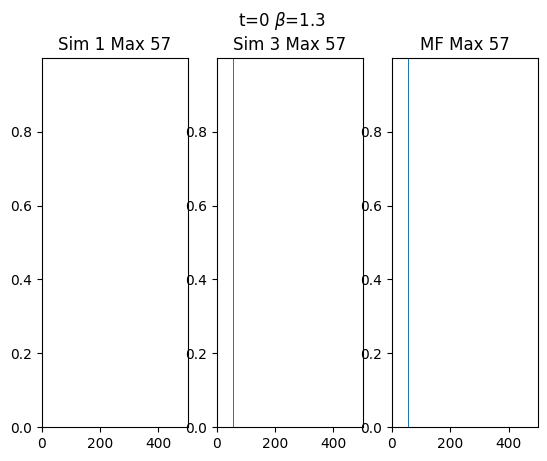

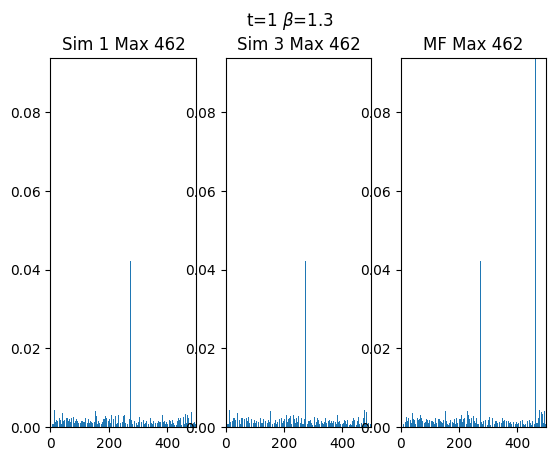

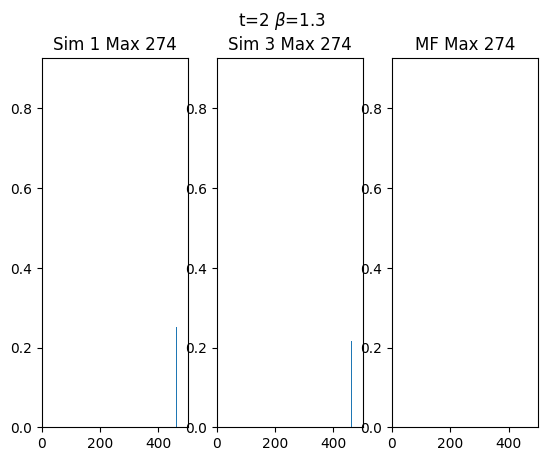

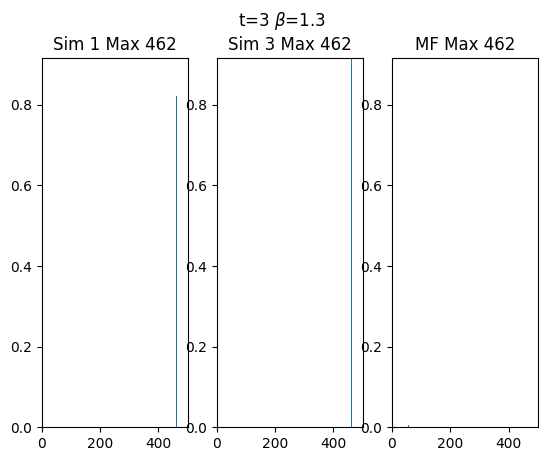

In [246]:
for i in range(len(timesteps_to_examine)):
    fig, ax = plt.subplots(1, 3)

    print(torch.allclose(probs_sim_t[0, i, :], probs_sim_t[1, i, :]), torch.allclose(probs_sim_t[0, i, :], probs_mf_t[i, :]))

    maxprob = torch.max(torch.cat((probs_sim_t[0, i, :], probs_sim_t[1, i, :], probs_mf_t[i, :])))

    print(maxprob, torch.max(probs_sim_t[0, i, :]), torch.max(probs_sim_t[1, i, :]), torch.max(probs_mf_t[i, :]))

    ax[0].bar(torch.arange(emb_size), probs_sim_t[0, i, :])
    ax[0].set_title(f"Sim {n_trials_to_examine[0]} Max {torch.argmax(probs_sim_t[0, i, :])}")
    ax[0].set_ylim(0, maxprob)
    ax[0].set_xlim(0, emb_size)
    ax[1].bar(torch.arange(emb_size), probs_sim_t[1, i, :])
    ax[1].set_title(f"Sim {n_trials_to_examine[1]} Max {torch.argmax(probs_sim_t[1, i, :])}")
    ax[1].set_ylim(0, maxprob)
    ax[1].set_xlim(0, emb_size)
    ax[2].bar(torch.arange(emb_size), probs_mf_t[i, :])
    ax[2].set_title(f"MF Max {torch.argmax(probs_mf_t[i, :])}")
    ax[2].set_ylim(0, maxprob)
    ax[2].set_xlim(0, emb_size)


    plt.suptitle(rf"t={timesteps_to_examine[i]} $\beta$={beta}")

Plot just the average of the simulated trajectory

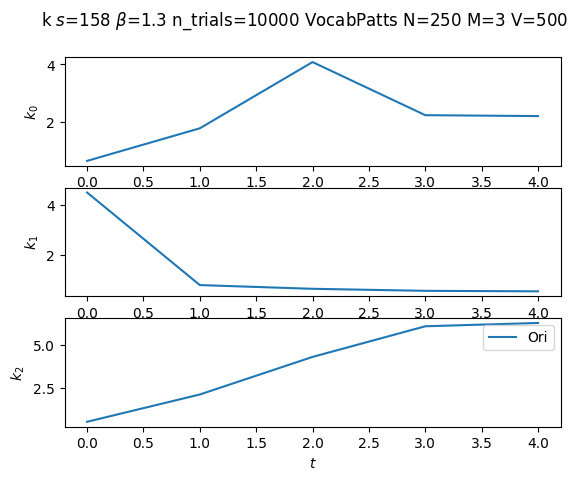

In [247]:
tag = "k"
if patterns_from_vocab:
    patterns_str = "VocabPatts"
else:
    patterns_str = "GaussianPatts"

stats = [tok_stats_sim_avg @ W_k.T]
# stats = [stat[num_patterns:num_patterns*3] for stat in stats]
label = ["Ori"]
line = ["-"]
title = rf"{tag} $s$={seed} $\beta$={beta} n_trials={num_trials} {patterns_str} N={token_size} M={num_patterns} V={emb_size}"
subplot_trajectories(stats, label, line, title, "k", random_feats=False, max_feats_show=3)

Now compare with MF

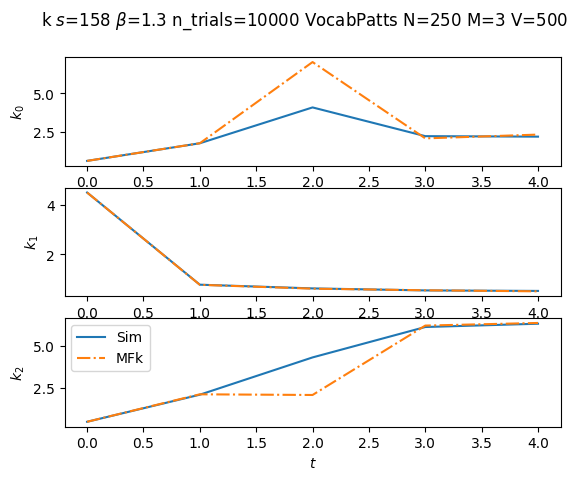

In [248]:
stats = [tok_stats_sim_avg @ W_k.T,  stats_k_mf]
label = ["Sim", "MFk"]
line = ["-", "-."]
subplot_trajectories(stats, label, line, title, "k", random_feats=True)

Show the mean and covariance for $q_t$ for the simulated and approximated model

In [249]:
for t in timesteps_to_examine:
    # mean and cov for the simulated model
    q_sim_mean_t = torch.mean(tok_stats_sim[:,t,:] @ W_k.T, dim=0)
    q_sim_cov_t = torch.cov((tok_stats_sim[:,t,:] @ W_k.T).T)

    dist_sim = torch.distributions.MultivariateNormal(loc=q_sim_mean_t, covariance_matrix=q_sim_cov_t)

    # Distribution for the approximated model

    dist_mf = torch.distributions.MultivariateNormal(loc=q_mf_t[t], covariance_matrix=q_mf_cov_t[t])

    grid = torch.linspace(-20, 20, 500)  # adjust range if mean is far from 0

    # Plot
    fig, axes = plt.subplots(1, 3)

    for i in range(3):
        # Simulated model
        # Prepare input: all means, but vary the selected dimension
        x_sim = q_sim_mean_t.repeat(len(grid), 1)  # shape: (grid_size, N)
        x_sim[:, i] = grid             # vary selected dimension

        logp_sim = dist_sim.log_prob(x_sim)
        p_sim = torch.exp(logp_sim).numpy()

        # Approximated model
        # Prepare input: all means, but vary the selected dimension
        x_mf = q_mf_t[t].repeat(len(grid), 1)  # shape: (grid_size, N)
        x_mf[:, i] = grid             # vary selected dimension

        logp_mf = dist_mf.log_prob(x_sim)
        p_mf = torch.exp(logp_mf).numpy()

        axes[i].plot(grid.numpy(), p_sim, label=f'Sim', color='steelblue')
        axes[i].plot(grid.numpy(), p_mf, "--", label=f'MF', color='darkseagreen')
        axes[i].set_title(f'Dim {i}')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Density')

        if i == 0:
            axes[i].legend(loc="upper right")

    fig.suptitle(rf"Marginal Density t={timesteps_to_examine[t]} $\beta$={beta}")


    print(q_sim_mean_t.shape, q_sim_cov_t.shape)

ValueError: Expected parameter covariance_matrix (Tensor of shape (3, 3)) of distribution MultivariateNormal(loc: torch.Size([3]), covariance_matrix: torch.Size([3, 3])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[ 2.7491e-06, -6.3811e-05,  1.2242e-05],
        [-6.3811e-05,  1.4812e-03, -2.8417e-04],
        [ 1.2242e-05, -2.8417e-04,  5.4518e-05]])

In [250]:
q_sim_cov_t

tensor([[ 2.7491e-06, -6.3811e-05,  1.2242e-05],
        [-6.3811e-05,  1.4812e-03, -2.8417e-04],
        [ 1.2242e-05, -2.8417e-04,  5.4518e-05]])

In [251]:
torch.linalg.eig((q_sim_cov_t + q_sim_cov_t.T)/2)

torch.return_types.linalg_eig(
eigenvalues=tensor([ 0.0000e+00+0.j,  1.5385e-03+0.j, -1.4138e-11+0.j]),
eigenvectors=tensor([[-0.9991+0.j, -0.0423+0.j, -0.0084+0.j],
        [-0.0415+0.j,  0.9812+0.j,  0.1881+0.j],
        [ 0.0080+0.j, -0.1882+0.j,  0.9821+0.j]]))

In [252]:
q_mf_cov_t[-1]

tensor([[0.0321, 0.0025, 0.0113],
        [0.0025, 0.0283, 0.0098],
        [0.0113, 0.0098, 0.0257]])

In [253]:
W_kq = W_k @ W_q.T
torch.linalg.eig(W_kq)

torch.return_types.linalg_eig(
eigenvalues=tensor([ 2.8394+0.j,  0.0117+0.j, -0.4274+0.j]),
eigenvectors=tensor([[ 0.5936+0.j,  0.8524+0.j,  0.7454+0.j],
        [ 0.2414+0.j,  0.0971+0.j, -0.6445+0.j],
        [ 0.7677+0.j, -0.5137+0.j,  0.1701+0.j]]))